In [2]:
%reload_ext autoreload
%autoreload 2

# Imports
Import the required classes and functions.

In [3]:
import lightgbm

from mleko.dataset.convert import CSVToVaexConverter
from mleko.dataset.feature_select import (
    CompositeFeatureSelector,
    MissingRateFeatureSelector,
    PearsonCorrelationFeatureSelector,
)
from mleko.dataset.ingest import KaggleIngester
from mleko.dataset.split import RandomSplitter
from mleko.dataset.transform import CompositeTransformer, LabelEncoderTransformer
from mleko.model import LGBMModel
from mleko.pipeline import Pipeline
from mleko.pipeline.steps import ConvertStep, FeatureSelectStep, IngestStep, ModelStep, SplitStep, TransformStep

# Constants
Define configuration variables.

In [4]:
# Kaggle dataset identifier
OWNER_SLUG = "jsphyg"
DATASET_SLUG = "weather-dataset-rattle-package"
DATASET_NAME = f"{OWNER_SLUG}/{DATASET_SLUG}"

# Dataset feature configuration
TARGET_FEATURE = "RainTomorrow"
DATE_FEATURE = "Date"
META_FEATURES = [TARGET_FEATURE, DATE_FEATURE]

# General Configuration
RANDOM_STATE = 1337

# Pipeline Setup

In [14]:
# Download the dataset from Kaggle
kaggle_data_source = KaggleIngester(
    destination_directory=f"data/{DATASET_NAME}/raw", owner_slug=OWNER_SLUG, dataset_slug=DATASET_SLUG
)

# Convert the CSV file to Apache Arrow format
csv_to_arrow_converter = CSVToVaexConverter(
    output_directory=f"data/{DATASET_NAME}/converted",
    na_values=["NA"],
    true_values=["Yes"],
    false_values=["No"],
    downcast_float=True,
    meta_columns=META_FEATURES,
    drop_rows_with_na_columns=[TARGET_FEATURE],
    random_state=RANDOM_STATE,
)

# Divide the dataset into train and test sets
random_data_splitter = RandomSplitter(
    cache_directory=f"data/{DATASET_NAME}/split",
    data_split=(0.80, 0.20),
    shuffle=True,
    stratify=TARGET_FEATURE,
    random_state=RANDOM_STATE,
)

# Configure all the feature selectors in a grouped composite feature selector
# The feature selectors are applied in the order they are defined and can be chained as needed
composite_feature_selector = CompositeFeatureSelector(
    cache_directory=f"data/{DATASET_NAME}/feature_select",
    feature_selectors=[
        MissingRateFeatureSelector(
            cache_directory=f"data/{DATASET_NAME}/feature_select",
            missing_rate_threshold=0.5,
            ignore_features=META_FEATURES,
        ),
        PearsonCorrelationFeatureSelector(
            cache_directory=f"data/{DATASET_NAME}/feature_select",
            correlation_threshold=0.6,
            ignore_features=META_FEATURES,
        ),
    ],
)

# Configure all the transformers in a grouped composite transformer
# The transformers are applied in the order they are defined and can be chained as needed
composite_transformer = CompositeTransformer(
    cache_directory=f"data/{DATASET_NAME}/transform",
    transformers=[
        LabelEncoderTransformer(
            cache_directory=f"data/{DATASET_NAME}/transform",
            features=["Location", "WindDir3pm", "WindDir9am", "WindGustDir", "RainToday", "RainTomorrow"],
        ),
    ],
)

lgbm_model = LGBMModel(
    cache_directory=f"data/{DATASET_NAME}/model",
    objective="binary",
    target=TARGET_FEATURE,
    num_iterations=100,
    ignore_features=META_FEATURES,
    metric=["average_precision", "auc"],
)

# Configure the pipeline and the data flow
pipeline = Pipeline(
    steps=[
        IngestStep(kaggle_data_source, outputs=["raw_csv"]),
        ConvertStep(csv_to_arrow_converter, inputs=["raw_csv"], outputs=["clean_data_schema", "df_clean"]),
        SplitStep(
            random_data_splitter,
            inputs=["df_clean"],
            outputs=["df_clean_train_validate", "df_clean_test"],
            cache_group="split_train_validate_test",
        ),
        FeatureSelectStep(
            composite_feature_selector,
            action="fit_transform",
            inputs=["clean_data_schema", "df_clean_train_validate"],
            outputs=["data_schema", "composite_feature_selector", "df_selected_train_validate"],
            cache_group="fit_transform_train_validate",
        ),
        FeatureSelectStep(
            composite_feature_selector,
            action="transform",
            inputs=["clean_data_schema", "df_clean_test"],
            outputs=["data_schema", "df_selected_test"],
            cache_group="transform_test",
        ),
        TransformStep(
            composite_transformer,
            action="fit_transform",
            inputs=["df_selected_train_validate"],
            outputs=["composite_transformer", "df_transformed_train_validate"],
            cache_group="fit_transform_train_validate",
        ),
        TransformStep(
            composite_transformer,
            action="transform",
            inputs=["df_selected_test"],
            outputs=["df_transformed_test"],
            cache_group="fit_transform_test",
        ),
        SplitStep(
            random_data_splitter,
            inputs=["df_transformed_train_validate"],
            outputs=["df_transformed_train", "df_transformed_validate"],
            cache_group="split_train_validate",
        ),
        ModelStep(
            lgbm_model,
            action="fit_transform",
            inputs=["data_schema", "df_transformed_train", "df_transformed_validate"],
            outputs=["lgbm_model", "metrics", "df_predictions_train", "df_predictions_validate"],
        ),
        ModelStep(
            lgbm_model,
            action="transform",
            inputs=["data_schema", "df_transformed_test"],
            outputs=["df_predictions_test"],
        ),
    ]
)

[2023-09-06 16:56:39] [INFO] Attempting to fetch Kaggle API credentials from environment variables 'KAGGLE_USERNAME' and 'KAGGLE_KEY'. (kaggle_ingester.py:74)
[2023-09-06 16:56:39] [INFO] Kaggle API credentials not found in environment variables, attempting to fetch from fallback path at ~/.kaggle/kaggle.json. (kaggle_ingester.py:82)
[2023-09-06 16:56:39] [INFO] Kaggle credentials successfully fetched. (kaggle_ingester.py:91)


# Run Pipeline

In [20]:
data_container =  pipeline.run().data

[2023-09-06 16:57:39] [INFO] No data container provided. Creating an empty one. (pipeline.py:77)
[2023-09-06 16:57:39] [INFO] Executing step 1/10: IngestStep. (pipeline.py:81)
[2023-09-06 16:57:39] [INFO] Cache Hit: Local dataset is up to date with Kaggle, skipping download. (kaggle_ingester.py:279)
[2023-09-06 16:57:39] [INFO] Finished step 1/10 execution. (pipeline.py:83)
[2023-09-06 16:57:39] [INFO] Executing step 2/10: ConvertStep. (pipeline.py:81)
[2023-09-06 16:57:39] [INFO] Cache Hit (LRUCache) CSVToVaexConverter.convert: Using cached output. (cache_mixin.py:160)
[2023-09-06 16:57:39] [INFO] Finished step 2/10 execution. (pipeline.py:83)
[2023-09-06 16:57:39] [INFO] Executing step 3/10: SplitStep. (pipeline.py:81)
[2023-09-06 16:57:39] [INFO] Cache Hit (LRUCache) RandomSplitter.split: Using cached output. (cache_mixin.py:160)
[2023-09-06 16:57:39] [INFO] Finished step 3/10 execution. (pipeline.py:83)
[2023-09-06 16:57:39] [INFO] Executing step 4/10: FeatureSelectStep. (pipeline.

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='auc'>

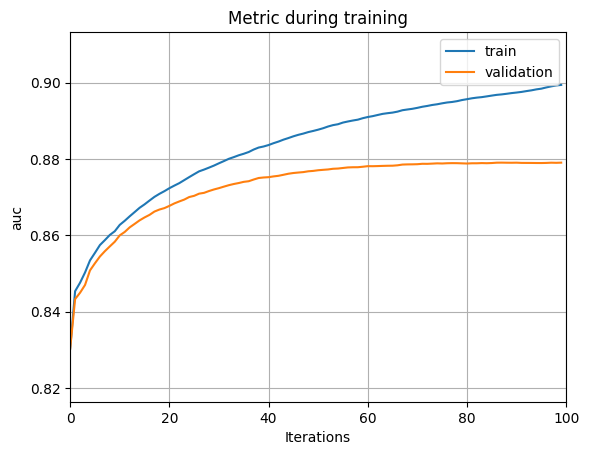

In [21]:
lightgbm.plot_metric(data_container['metrics'], metric='auc')